# Analysing molecular dynamics simulation

This notebook demonstrates how the `simulation` module of `refnx` can be used to obtain reflectometry data from a molecular simulation trajectory. 

The first step in most Python scripts is to import modules and functions that are going to be used. 

In [1]:
# use matplotlib for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path

import refnx, scipy

# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset

# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import ReflectModel, Simulation

# the analysis module contains the curvefitting engine
from refnx.analysis import Objective, Transform, CurveFitter

In order for the analysis to be exactly reproducible the same package versions must be used. The conda packaging manager, and pip, can be used to ensure this is the case.

In [2]:
# version numbers used in this analysis
refnx.version.version, scipy.version.version

('0.0.18.dev0+bbdf12f', '1.1.0')

The `Simulation` class is used to represent the scattering length density profile that is obtained from the molecular dynamics simulation output. The `simulation.pdb` is a molecular dynamics trajectory consisting of 24327 atoms for 6 timestep of simulation. The `simulation.lgt` is a text which that assigns the scattering lengths of the individual atoms, not in this example the simulation used a united-atom model, where all of the hydrogen atoms are integrated into the atoms to which they are bound. The `simulation.lgt` file takes the form of a space-separated file consisting of the atom name, real scattering length, and imaginary scattering length. 

The `Simulation` class takes the $z = 0$ point as the plane that the neutrons or X-ray are penetrating from, therefore it may be necessary to `flip` the simulation cell. 

In [3]:
pth = os.path.join(os.path.dirname(refnx.__file__), 'reflect', 'test')

sim = Simulation(os.path.join(pth, 'simulation.pdb'), lgtfile=os.path.join(pth, 'simulation.lgt'), flip=True)

It is then possible to plot the determined scattering length density profile, as shown below.

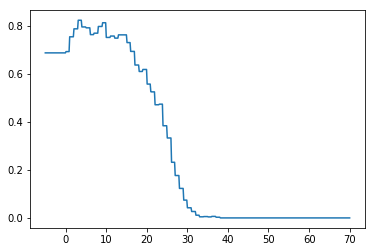

In [4]:
plt.plot(sim.sld_profile()[0], sim.sld_profile()[1])

Since the reflectometry is determined from simulation, it is necessary to fit the reflectometry to the a dataset by varing the scale and background. This is achieved by defining the relevant data for the simulation performed and using the `CurveFitter` and `Objective` classes, as discussed in [getting started](./getting_started.ipynb). 

In [5]:
dataset = ReflectDataset(os.path.join(pth, 'simulation.dat'))
model = ReflectModel(sim)
model.scale.setp(100, vary=True, bounds=(0.001, np.inf))
model.bkg.setp(dataset.y[-1], vary=True, bounds=(0, np.inf))
objective = Objective(model, dataset, transform=Transform('YX4'))
fitter = CurveFitter(objective)
res = fitter.fit()
print(objective)

________________________________________________________________________________
Objective - 139691462609496
Dataset = example
datapoints = 51
chi2 = 4352.772598345131
Weighted = True
Transform = <refnx.analysis.objective.Transform object at 0x7f0c7401d278>
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    value=    43.5851              , bounds=[0.001, inf]>
<Parameter:     'bkg'     value=  1.88809e-06            , bounds=[0, inf]>
<Parameter:'dq - resolution'value=       5        (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'traj: /home/arm61/anaconda3/envs/ref_fal/lib/python3.7/site-packages/refnx-0.0.18.dev0+bbdf12f-py3.7-linux-x86_64.egg/refnx/reflect/test/simulation.pdb \n lgt: /home/arm61/anaconda3/env

It is then possible to plot the simulation-derived reflectometry against the experimental data. 

Text(0,0.5,'Reflectivity')

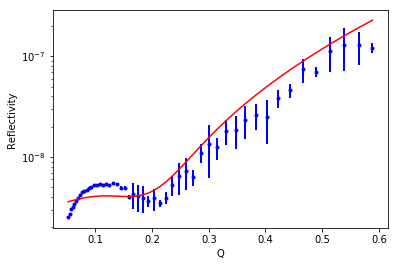

In [6]:
objective.plot()
plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')